# COVID19 CASES

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests

from pathlib import Path
from zipfile import ZipFile

## Shapefiles

In [3]:
shapefile = 'gemeente_2020_v1.shp'

In [4]:
# Download data
download_dir = Path('../downloads')
download_dir.mkdir(exist_ok=True)

url = 'https://www.cbs.nl/-/media/cbs/dossiers/nederland-regionaal/wijk-en-buurtstatistieken/wijkbuurtkaart_2020_v1.zip'
filename = url.split('/')[-1]

if not Path(download_dir /filename).is_file():
    try:
        r = requests.get(url)
        with open(download_dir /filename,'wb') as output_file:
            output_file.write(r.content)
    except:
        pass

In [5]:
# Extract data
shapefiles_dir = Path('../shapefiles')
shapefiles_dir.mkdir(exist_ok=True)

if not Path(shapefiles_dir /shapefile).is_file():
    with ZipFile(download_dir /filename, 'r') as zipObj:
        zipObj.extractall(shapefiles_dir)

In [6]:
# Read data
gdf = gpd.read_file(shapefiles_dir / shapefile)
gdf.sample(n=3)

,GM_CODE,JRSTATCODE,GM_NAAM,H2O,OAD,STED,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,...,P_ANT_ARU,P_SURINAM,P_TURKIJE,P_OVER_NW,OPP_TOT,OPP_LAND,OPP_WATER,Shape_Leng,Shape_Area,geometry
326,GM0873,2020GM0873,Woensdrecht,NEE,664,4,239,21876,10982,10894,...,0,0,0,2,9197,9166,31,48462.377484,9.197008e+07,"POLYGON ((78984.163 384601.500, 79065.608 3849..."
223,GM0451,2020GM0451,Uithoorn,NEE,1429,3,1625,29478,14513,14965,...,1,2,1,9,1942,1814,128,24200.747538,1.941905e+07,"POLYGON ((113599.091 474115.275, 113599.106 47..."
254,GM0590,2020GM0590,Papendrecht,NEE,1920,2,3414,32136,15799,16337,...,1,2,1,5,1079,941,138,14916.683989,1.078996e+07,"POLYGON ((106299.992 428683.878, 106300.571 42..."


In [7]:
# Filter rows (i.e. land only) and select columns
gemeente = gdf.loc[gdf.H2O=='NEE', ['GM_NAAM', 'AANT_INW', 'geometry']]
gemeente.sample(n=3)

,GM_NAAM,AANT_INW,geometry
231,Drechterland,19719,"POLYGON ((139648.090 523756.370, 139650.159 52..."
209,Hilversum,90831,"POLYGON ((138206.833 472115.685, 138206.499 47..."
398,Olst-Wijhe,18252,"POLYGON ((204953.488 488217.014, 204985.493 48..."


## COVID-19 data

In [8]:
base_url = 'https://data.rivm.nl/covid-19'
file_name = 'COVID-19_aantallen_gemeente_per_dag.csv'

In [9]:
data_dir = Path('../data')
data_dir.mkdir(exist_ok=True)

try:
    rivm = pd.read_csv(f'{base_url}/{file_name}', sep=';')
    print(f'Data downloaded from {base_url}')
except:
    print('Data read from disk')
    rivm = pd.read_csv(data_dir / 'rivm.csv', sep=';')

Data downloaded from https://data.rivm.nl/covid-19


In [10]:
datum = '2021-01-05'

In [11]:
df = rivm.loc[rivm.Date_of_publication == datum, ['Municipality_name', 'Total_reported']]\
.dropna().groupby(by = 'Municipality_name').sum('Total_reported').reset_index()
df.sample(n=5)

,Municipality_name,Total_reported
349,Zwartewaterland,5
122,Hattem,5
292,Utrechtse Heuvelrug,19
264,Smallingerland,13
218,Olst-Wijhe,4


## Merge datasets

In [12]:
gdf = pd.merge(gemeente, df, how='left', left_on='GM_NAAM', right_on='Municipality_name')
gdf.drop('Municipality_name', axis=1, inplace=True)
gdf['AANT_COVID_100K'] = 100_000 / gdf.AANT_INW * gdf.Total_reported # Aantal besmettingen per 100.000 inwoners
gdf.sample(n=5)

,GM_NAAM,AANT_INW,geometry,Total_reported,AANT_COVID_100K
147,Barendrecht,48714,"POLYGON ((92892.344 429770.211, 92886.107 4297...",8.0,16.422384
187,Borsele,22739,"MULTIPOLYGON (((53920.500 385405.000, 53937.93...",6.0,26.386385
160,Hillegom,22209,"POLYGON ((99060.473 476481.485, 99058.778 4764...",6.0,27.016075
48,Barneveld,59082,"POLYGON ((166062.109 465254.057, 166062.427 46...",42.0,71.087641
125,Den Helder,56296,"MULTIPOLYGON (((109617.583 547478.374, 109599....",27.0,47.960779


In [13]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 355 entries, 0 to 354
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   GM_NAAM          355 non-null    object  
 1   AANT_INW         355 non-null    int64   
 2   geometry         355 non-null    geometry
 3   Total_reported   350 non-null    float64 
 4   AANT_COVID_100K  350 non-null    float64 
dtypes: float64(2), geometry(1), int64(1), object(1)
memory usage: 16.6+ KB


## GeoPandas

In [14]:
column = 'AANT_COVID_100K'
title = 'COVID-10 besmettingen per 100.000 inwoners'

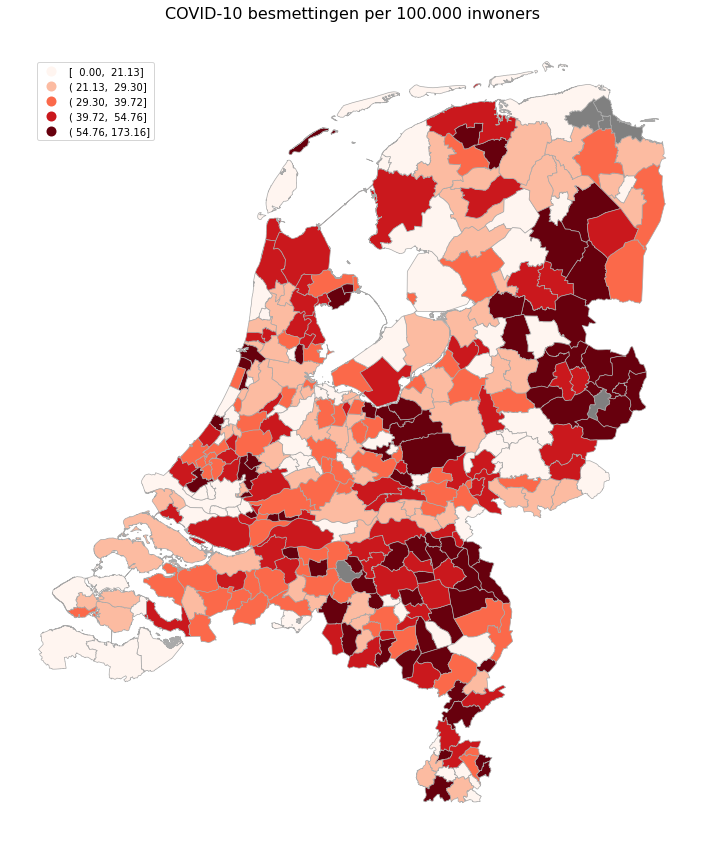

In [15]:
# Quantiles
f, ax = plt.subplots(1, figsize=(15, 15))
ax = gdf[pd.isnull(gdf[column])].plot(ax=ax, linewidth=.7, edgecolor='darkgrey', color='grey')
ax = gdf[~pd.isnull(gdf[column])].plot(ax=ax, linewidth=.7, edgecolor='darkgrey', cmap='Reds',
                                  column=column, legend=True, scheme='quantiles')
ax.set_title(title, fontsize=16)
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.22, -0.04, 0, 1))
plt.axis('off')
plt.show()

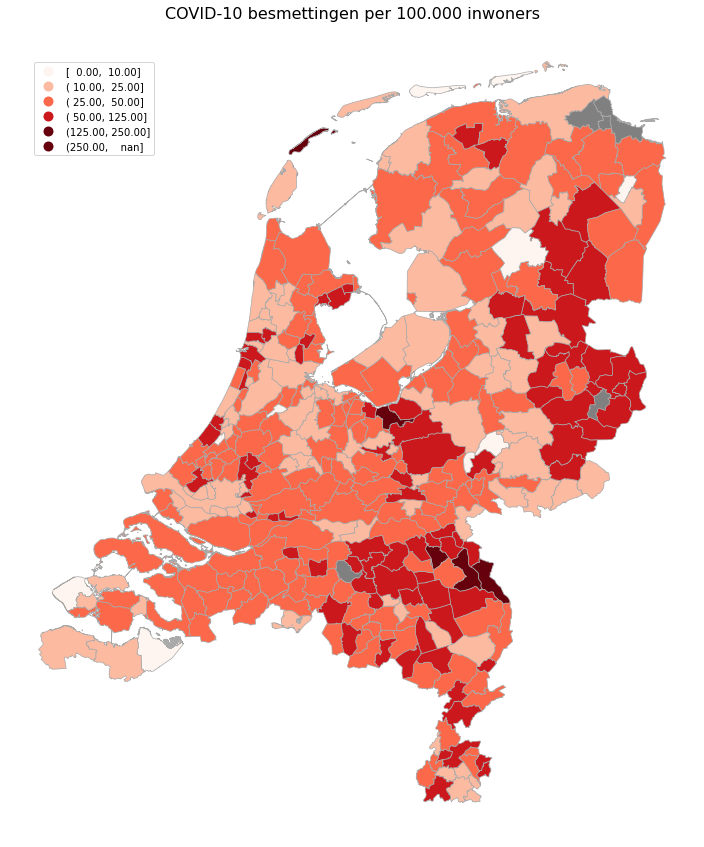

In [16]:
# User defined bins
f, ax = plt.subplots(1, figsize=(15, 15))
ax = gdf[pd.isnull(gdf[column])].plot(ax=ax, linewidth=.7, edgecolor='darkgrey', color='grey')
ax = gdf[~pd.isnull(gdf[column])].plot(ax=ax, linewidth=.7, edgecolor='darkgrey', cmap='Reds',
                                  column=column, legend=True, scheme='User_Defined',
                                  classification_kwds=dict(bins=[10, 25, 50, 125, 250, max(gdf[column])]))
ax.set_title(title, fontsize=16)
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.22, -0.04, 0, 1))
plt.axis('off')
plt.show()

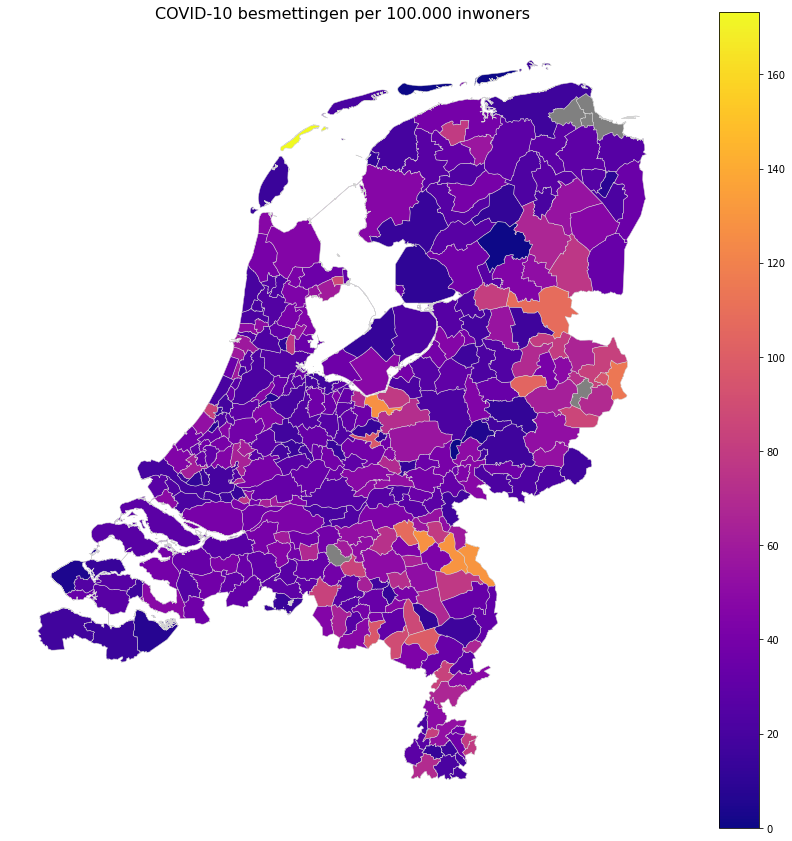

In [17]:
# colorbar
f, ax = plt.subplots(1, figsize=(15, 15))
ax = gdf[pd.isnull(gdf[column])].plot(ax=ax, linewidth=.5, edgecolor='lightgrey',
                                      color='grey')
ax = gdf[~pd.isnull(gdf[column])].plot(ax=ax, linewidth=.5, edgecolor='lightgrey',
                                       cmap='plasma', legend=True, column=column)
ax.set_title(title, fontsize=16)
plt.axis('off')
plt.savefig('../output/geopandas.png')
plt.show()